# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Цель проекта:** построить модель для определения стоимости автомобиля, чтобы качество предсказания, скорость предсказания, время обучения модели были наилучшие.

**План исследования:**
- загрузить и изучить данные
- обработать пропуски и аномалии
- обучить минимум две модели: LGBMRegressor и не бустинг
- проанализировать время обучения, время предсказания и качество моделей
- опираясь на критерии заказчика, выбрать лучшую модель

In [1]:
!pip install --upgrade scikit-learn -q
!pip install phik -q
!pip install missingno -q 
!pip install wordcloud==1.8.2.2 -q
!pip install --upgrade Pillow==9.5.0 -q

In [2]:
# импортируем библиотеки
import pandas as pd 
import numpy as np
import re 
import matplotlib.pyplot as plt 
import time
from tqdm import tqdm
import missingno as msno

import seaborn as sns 
sns.set(style="whitegrid")

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split 

from sklearn.pipeline import Pipeline 

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer 

from sklearn.impute import SimpleImputer

from sklearn.base import TransformerMixin, BaseEstimator

from sklearn.model_selection import RandomizedSearchCV 

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error

from phik.report import plot_correlation_matrix 

import warnings 
warnings.filterwarnings("ignore") 

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Подготовка данных

**Изучите данные. Заполните пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их.
Подготовьте выборки для обучения моделей.**

In [4]:
data = pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Присутствуют пропуски и можно привести названия столбцов к змеиному регистру.

In [6]:
# функция для преобразования нзваний столбцов
def to_snake_case(name):
    name = re.sub(r'([a-z])([A-Z])', r'\1_\2', name)
    name = re.sub(r'\s+', '_', name)
    return name.lower()

data.columns = [to_snake_case(col) for col in data.columns]

data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

Пропуски в таблице:
vehicle_type    37490
gearbox         19833
model           19705
fuel_type       32895
repaired        71154
dtype: int64


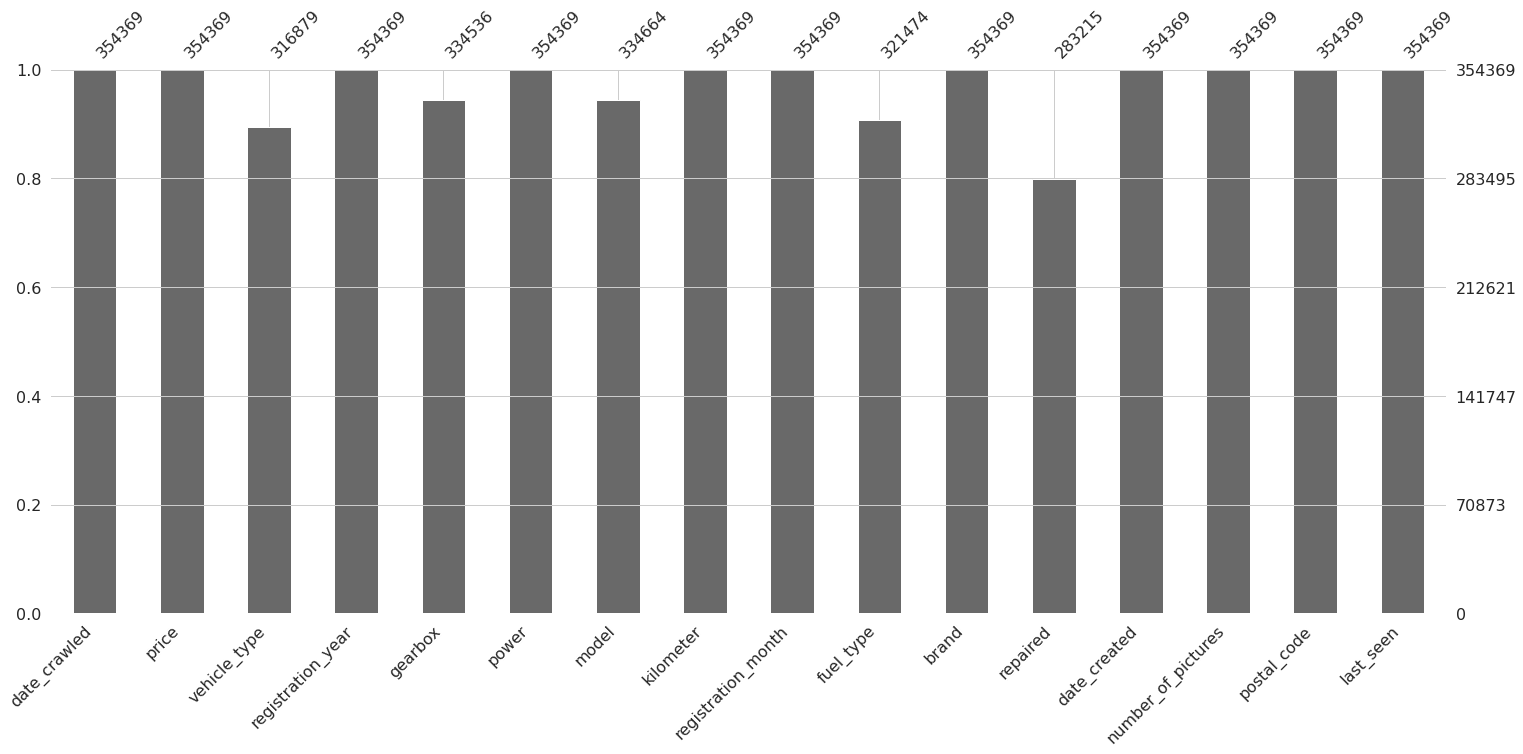

<Figure size 720x360 with 0 Axes>

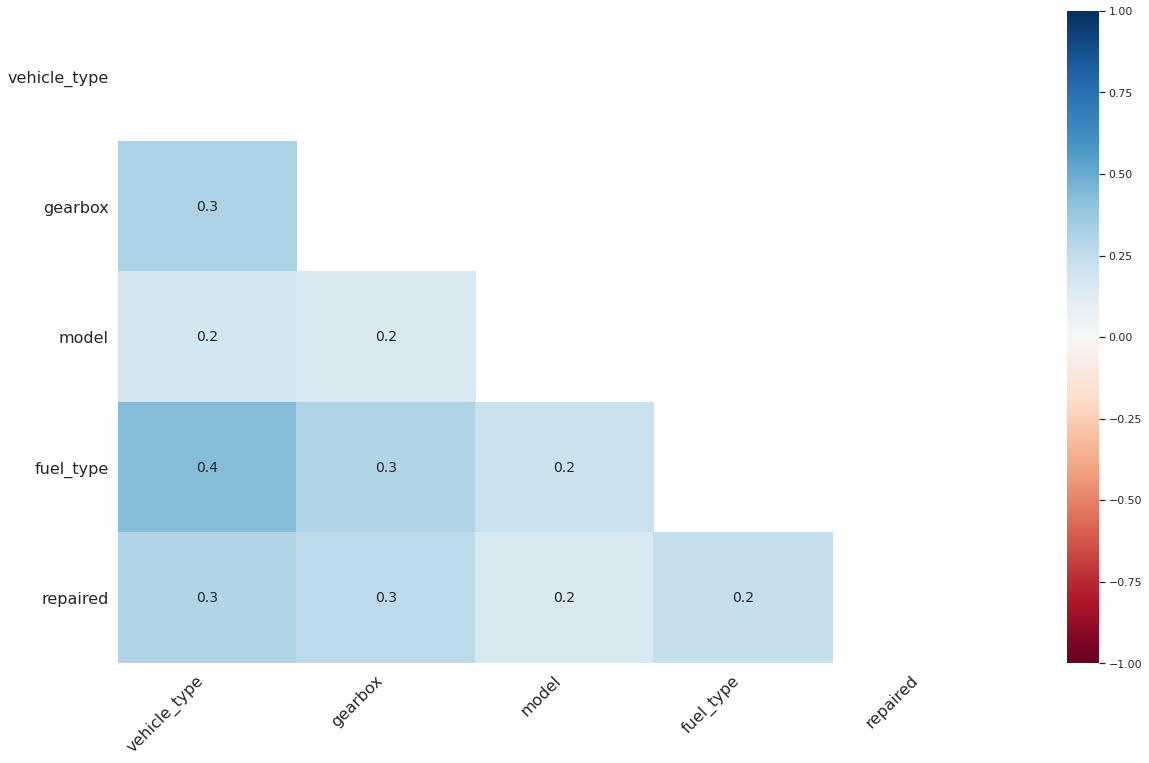


Явные дубликаты удалены! Их было 4.


In [7]:
# проверим пропуский в данных и явные дубликаты
def check_missing_and_duplicates(data):
    print('Пропуски в таблице:')
    missing_values = data.isna().sum()
    print(missing_values[missing_values > 0])  # Выведем только те столбцы, где есть пропуски
    
    # Визуализация пропусков
    plt.figure(figsize=(10, 5))
    msno.bar(data)
    plt.show()

    plt.figure(figsize=(10, 5))
    msno.heatmap(data)
    plt.show()

    # Проверка дубликатов
    duplicates = data.duplicated().sum()
    print()
    if duplicates > 0:
        data.drop_duplicates(inplace=True)
        print(f'Явные дубликаты удалены! Их было {duplicates}.')
    else:
        print('Нет явных дубликатов!')

check_missing_and_duplicates(data)


На первом графике можем оценить долю пропусков по каждому признаку, и тепловая карта показывает корреляцию между пропусками: fuel_type и vehicle_type имеют умеренную зависимость. В целом пропуски происходят случайно.

In [8]:
# смотрим типы данных
data.dtypes

date_crawled          object
price                  int64
vehicle_type          object
registration_year      int64
gearbox               object
power                  int64
model                 object
kilometer              int64
registration_month     int64
fuel_type             object
brand                 object
repaired              object
date_created          object
number_of_pictures     int64
postal_code            int64
last_seen             object
dtype: object

C типами данных всё в порядке.

In [9]:
# проверим данные в каждом столбце с категориальным признаком на неявные дубликаты
for column in data[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']]:
    data[column] =  data[column].str.strip().str.lower()
    print(f"Дубликаты в столбце '{column}':")
    print(data[column].value_counts())
    print()

Дубликаты в столбце 'vehicle_type':
sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: vehicle_type, dtype: int64

Дубликаты в столбце 'gearbox':
manual    268249
auto       66283
Name: gearbox, dtype: int64

Дубликаты в столбце 'model':
golf                  29232
other                 24420
3er                   19761
polo                  13066
corsa                 12570
                      ...  
serie_2                   8
rangerover                4
serie_3                   4
range_rover_evoque        2
serie_1                   2
Name: model, Length: 250, dtype: int64

Дубликаты в столбце 'fuel_type':
petrol      216349
gasoline     98719
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

Дубликаты в столбце 'brand':
volkswagen        77012
opel              39931
bmw              

Есть дубликат в виде 'petrol' и 'gasoline', как это одно и то же и нужно их объединить.

In [10]:
# делаем замену 'gasoline' на 'petrol' и проверяем
data['fuel_type'] = data['fuel_type'].replace({'gasoline':'petrol'})
data['fuel_type'].value_counts()

petrol      315068
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

Проведу корреляционный анализ признаков, чтобы посмотреть, есть ли неинформативные совсем признаки, и тогда буду заполнять пропуски.

Пропуски заполнены.

Проводим далее исследовательский анализ признаков.

In [11]:
# добавим новые столбцы, где дату переведем в формат int в виде числа дней со дня скачивания, создания анкеты и последней активности пользователя
data['date_crawled'] = pd.to_datetime(data['date_crawled'])
data['date_created'] = pd.to_datetime(data['date_created'])
data['last_seen'] = pd.to_datetime(data['last_seen'])

latest_date = data['date_crawled'].max()

data['days_since_crawl'] = (latest_date - data['date_crawled']).dt.days
data['days_since_creation'] = (latest_date - data['date_created']).dt.days
data['days_since_last_seen'] = (latest_date - data['last_seen']).dt.days

# проверим максимальный год регистрации
max_date_crawled = data['date_crawled'].max()
print(f"Наибольшая дата скачивания анкеты: {max_date_crawled}")

data = data.drop(columns=['date_crawled', 'date_created', 'last_seen'], errors='ignore')
                 
data.head()

Наибольшая дата скачивания анкеты: 2016-04-07 14:36:58


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,number_of_pictures,postal_code,days_since_crawl,days_since_creation,days_since_last_seen
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,0,70435,14,14,0
1,18300,coupe,2011,manual,190,NaN,125000,5,petrol,audi,yes,0,66954,14,14,0
2,9800,suv,2004,auto,163,grand,125000,8,petrol,jeep,NaN,0,90480,24,24,2
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,0,91074,20,21,20
4,3600,small,2008,manual,69,fabia,90000,7,petrol,skoda,no,0,60437,6,7,1


Значит будет смотреть даты не позднее 2016 года.

In [12]:
data.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code,days_since_crawl,days_since_creation,days_since_last_seen
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800,16.486129,17.199924,8.123150
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078,9.100653,9.386204,9.173556
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000,0.000000,0.000000,-1.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000,8.000000,9.000000,1.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000,16.000000,17.000000,3.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000,25.000000,25.000000,15.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000,33.000000,759.000000,33.000000


Признаки  registration_month и number_of_pictures можно смело удалять так как они не информативные.

In [13]:
data = data.drop(columns=['number_of_pictures', 'registration_month'])

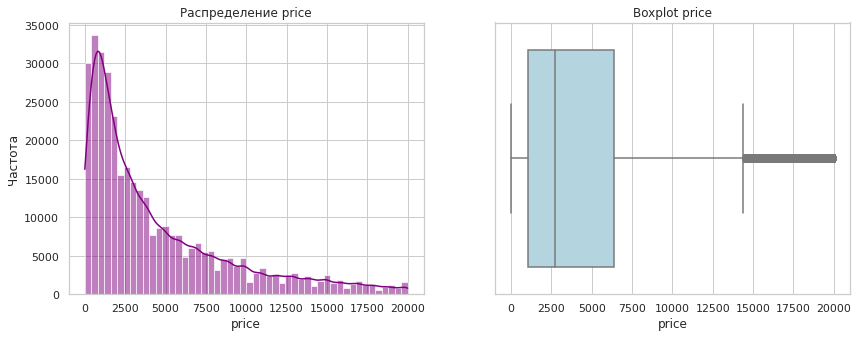

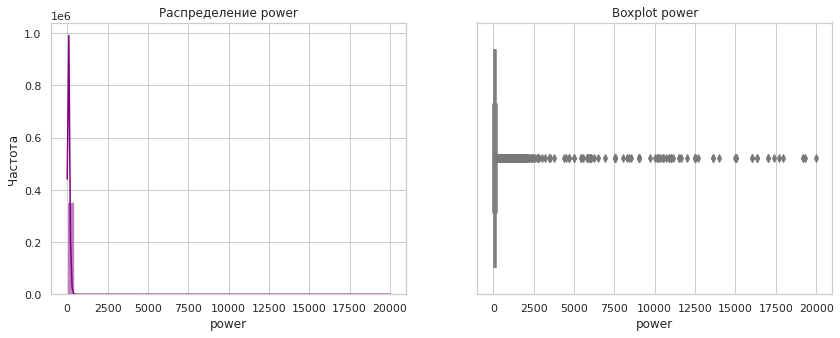

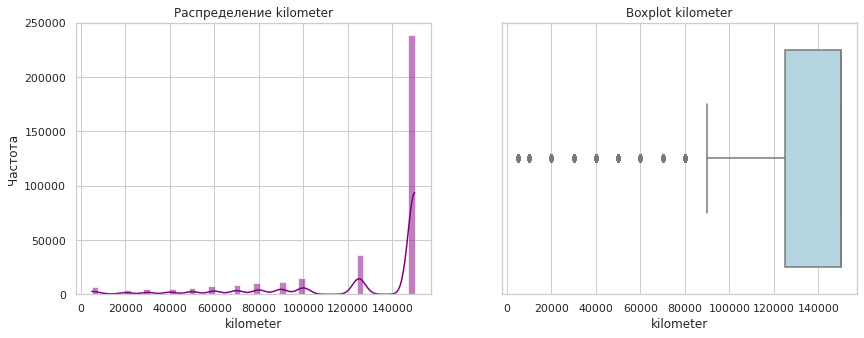

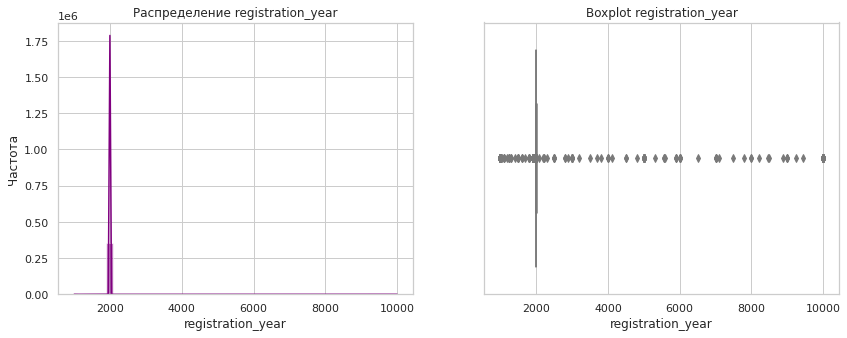

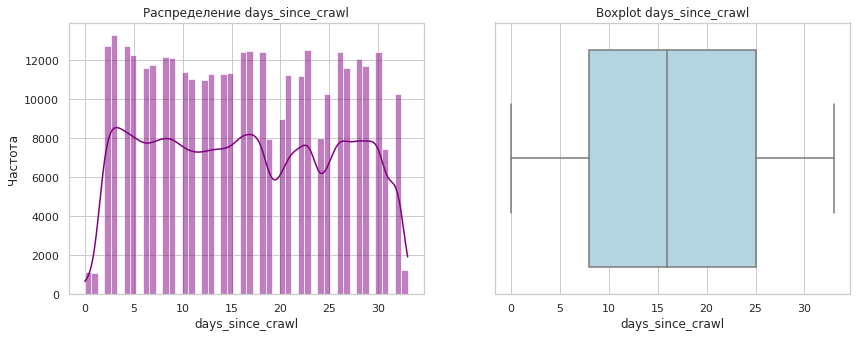

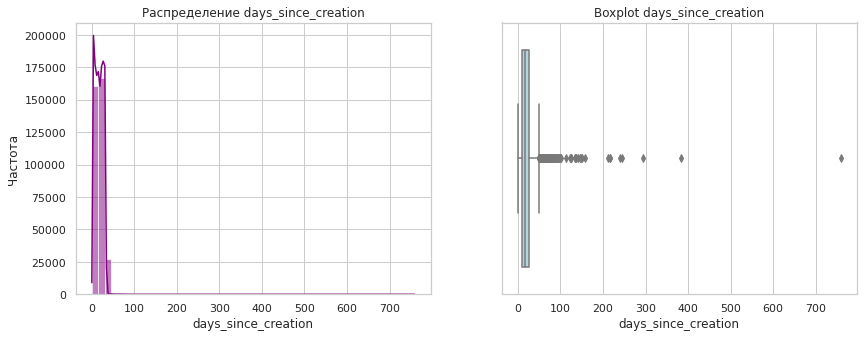

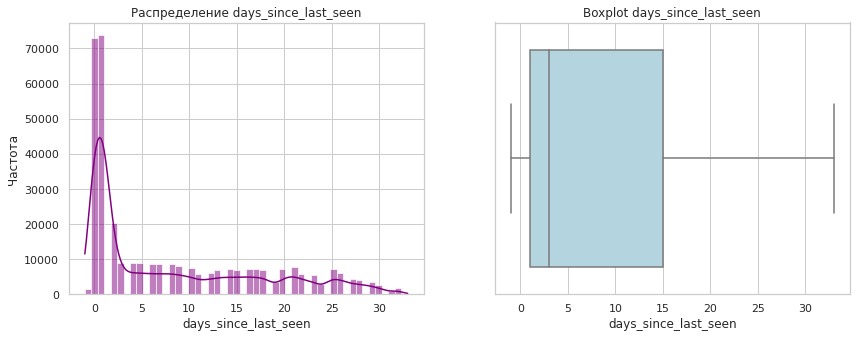

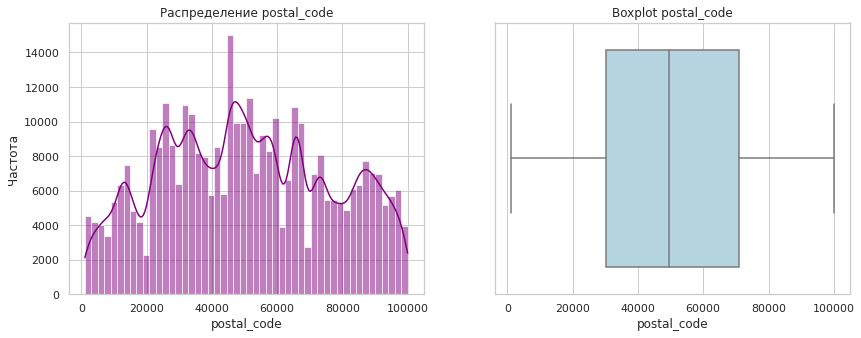

In [14]:
quant_columns = ['price', 'power', 'kilometer', 'registration_year', 'days_since_crawl', 'days_since_creation', 'days_since_last_seen', 'postal_code']
cat_columns = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired']
cloud_columns = ['model', 'brand']

# гистограммы и boxplot для непрерывных признаков
for col in quant_columns:
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    sns.histplot(data[col], kde=True, bins=50, color='purple', ax=ax[0])
    ax[0].set_title(f'Распределение {col}')
    ax[0].set_xlabel(col)
    ax[0].set_ylabel('Частота')

    sns.boxplot(x=data[col], color='lightblue', ax=ax[1])
    ax[1].set_title(f'Boxplot {col}')
    
    plt.show()

Есть аномалии в power, оставим только мощности меньше 2000 л.с. и больше 0. Также аномалии в registration_year.

In [15]:
# очищаем данные
data = data[(data['power'] <= 1000) & (data['power'] > 0)]
data = data[(data['registration_year'] >= 1950) & (data['registration_year'] <= 2016)]

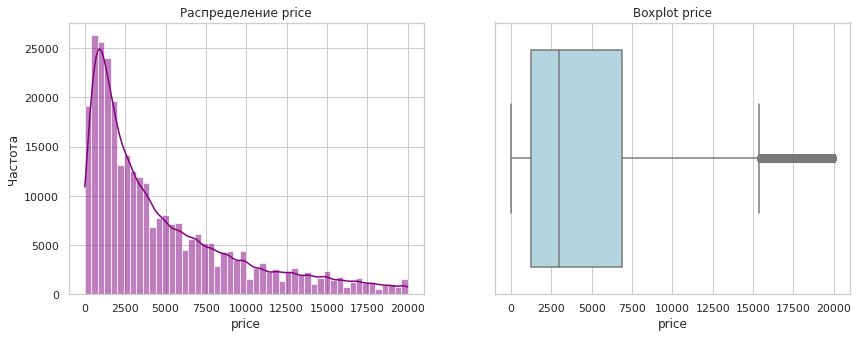

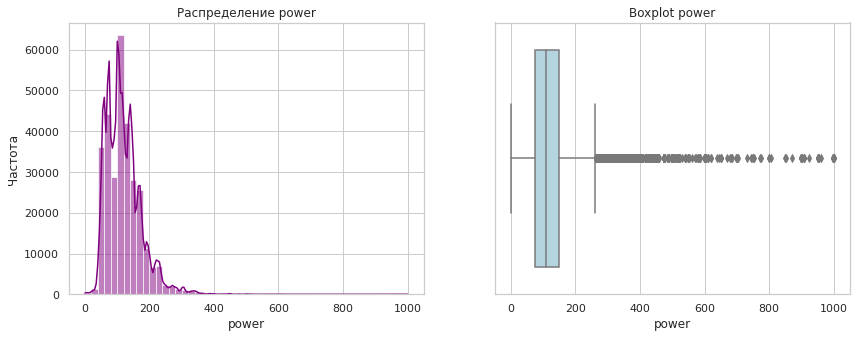

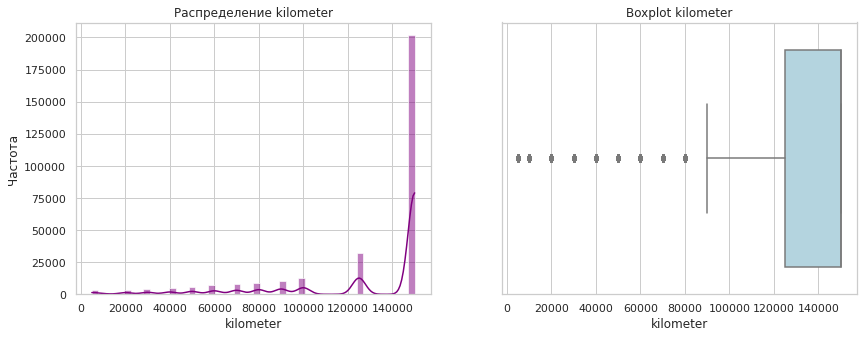

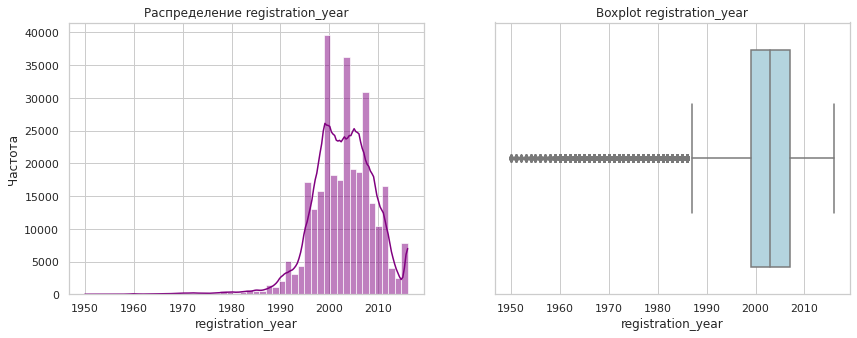

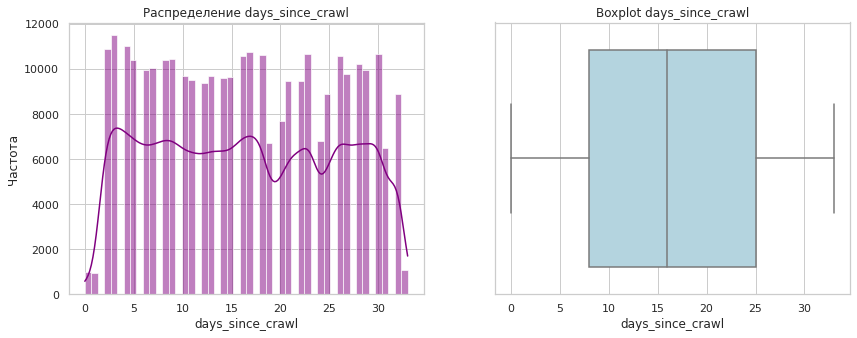

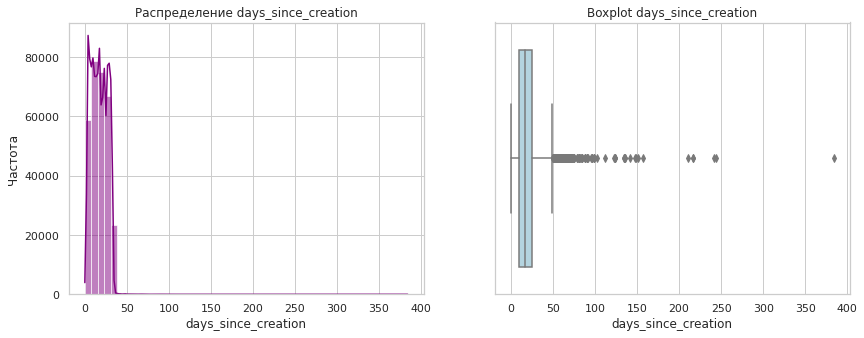

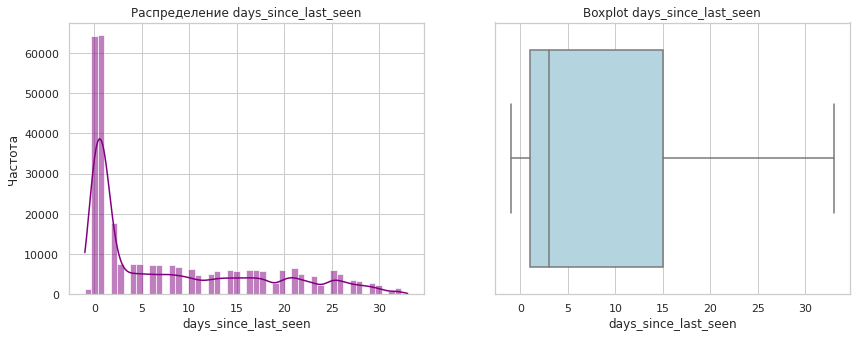

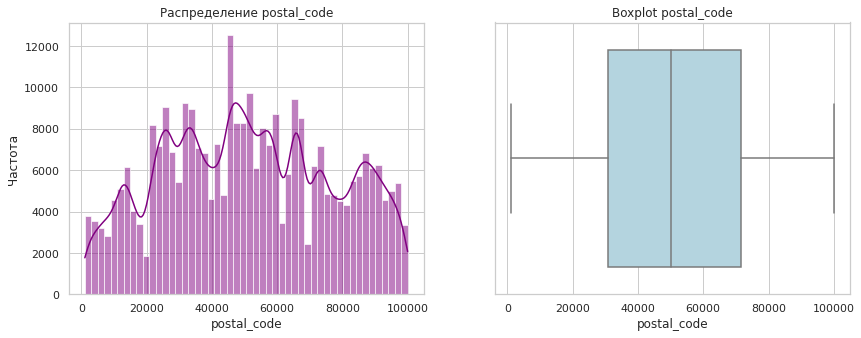

In [16]:
# гистограммы и boxplot для непрерывных признаков
for col in quant_columns:
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    sns.histplot(data[col], kde=True, bins=50, color='purple', ax=ax[0])
    ax[0].set_title(f'Распределение {col}')
    ax[0].set_xlabel(col)
    ax[0].set_ylabel('Частота')

    sns.boxplot(x=data[col], color='lightblue', ax=ax[1])
    ax[1].set_title(f'Boxplot {col}')
    
    plt.show()

Медианная цена находится в районе 2700, медианная мощность 105.

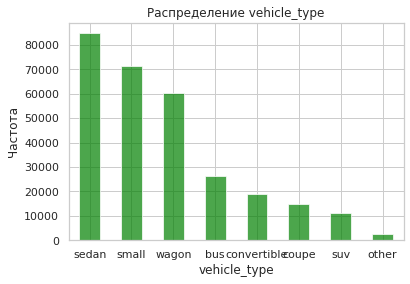

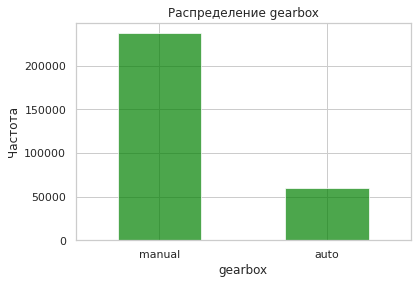

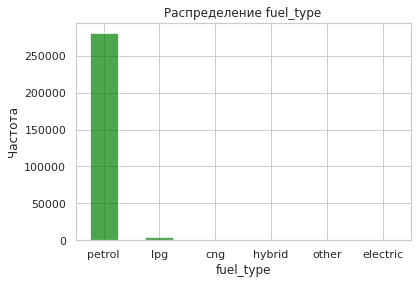

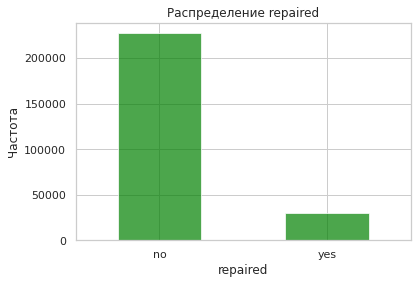

In [17]:
# столбчатые диаграммы для категориальных признаков
for col in cat_columns:
    plt.figure()
    data[col].value_counts().plot(kind='bar', color='green', alpha=0.7)
    plt.title(f'Распределение {col}')
    plt.xlabel(col)
    plt.ylabel('Частота')
    if col == 'популярная_категория':
        plt.xticks(rotation=75)
    else:
        plt.xticks(rotation=0)
    plt.show()

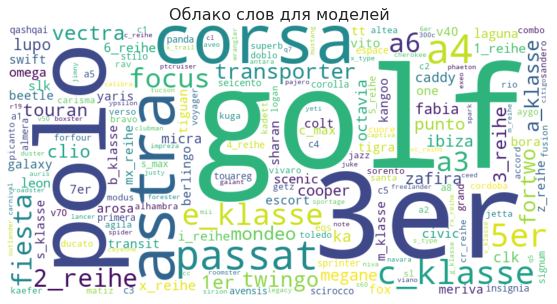

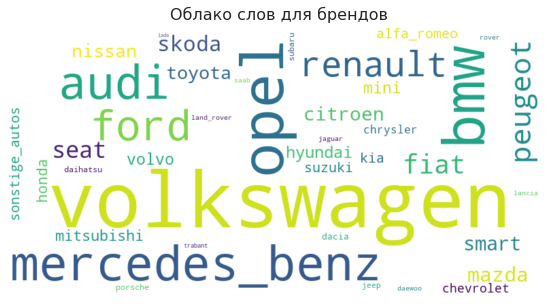

In [18]:
# функция для отображения облака слов
def plot_wordcloud(data, column, title):
    text = ' '.join(data[column].dropna())  # Объединяем все значения в строку
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)  # Генерация облака слов

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Убираем оси
    plt.title(title, fontsize=16)
    plt.show()

plot_wordcloud(data, 'model', 'Облако слов для моделей')
plot_wordcloud(data, 'brand', 'Облако слов для брендов')

Sedan самый популярный тип транспорта, механика преоблдает сильно, golf попклярная модель, petrol самое популярное топливо, volkswagen самый частовстречающийся бренд, большинство машин не чиненные ни разу.

Далее строим корреляционную матрицу.

In [19]:
# выделяем количественные (не дискретные) признаки
quant_columns_matrix = ['price', 'power', 'kilometer', 'registration_year', 'days_since_crawl', 'days_since_creation', 'days_since_last_seen']

# рассчитаем матрицу корреляции Phik
phik_matrix = data.sample(50000).phik_matrix(interval_cols=quant_columns_matrix)

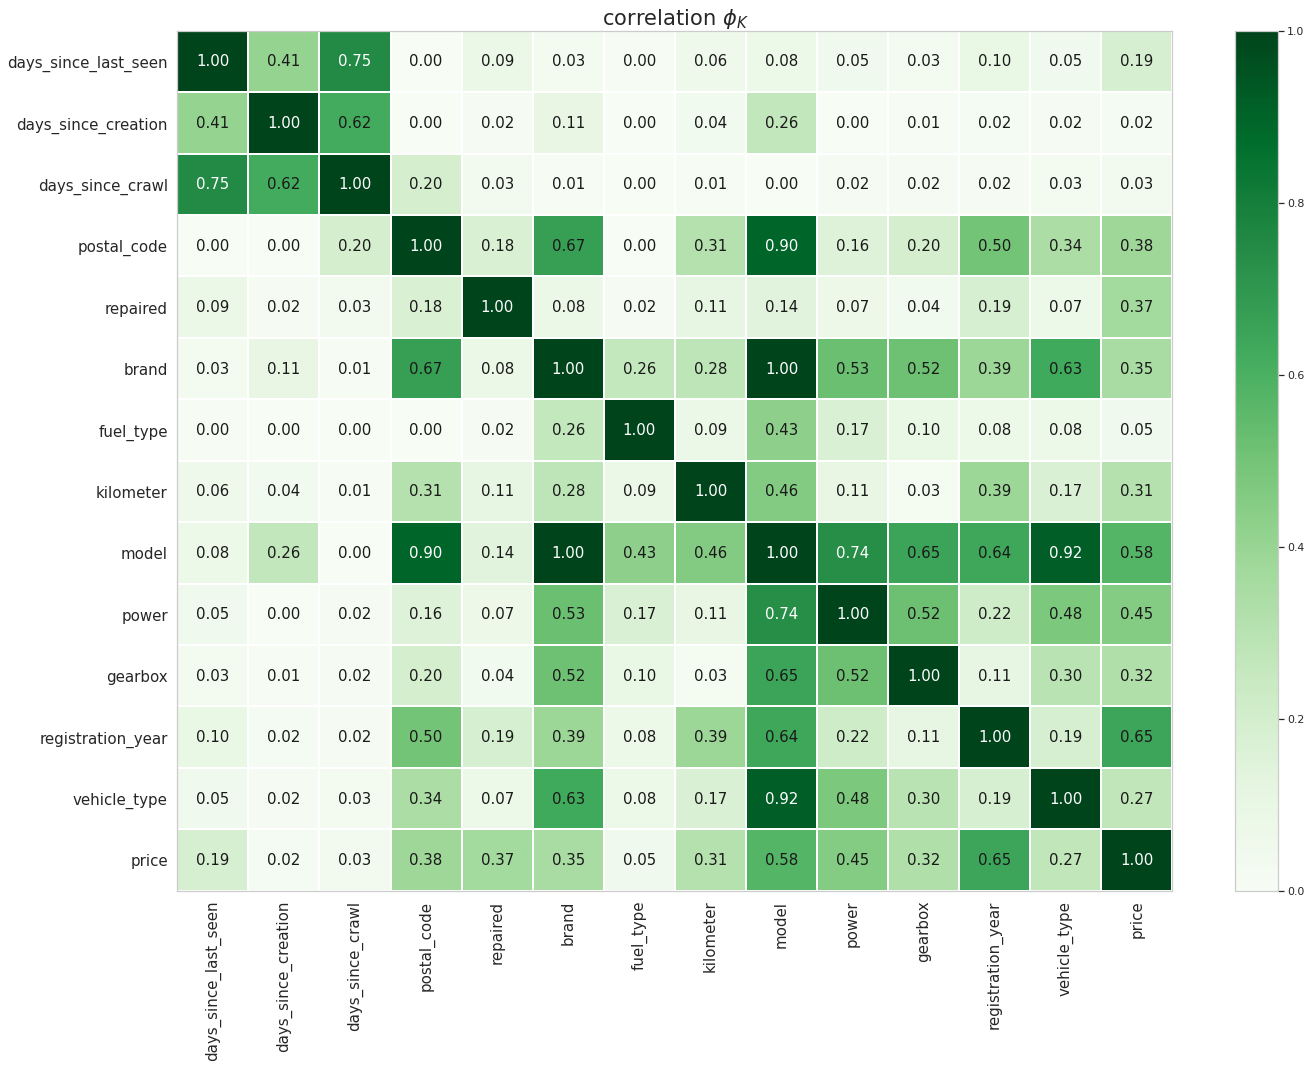

In [20]:
# визуализируем корреляционную матрицу
plot_correlation_matrix(
    phik_matrix.values,
    x_labels=phik_matrix.columns,
    y_labels=phik_matrix.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

Удалим признаки days_since_creation, days_since_crawl, days_since_last_seen, fuel_type, так как они слабо не коррелируют с целевым.

Наблюдается мультиколлинеарность между brand и model, model и vehicle_type, model и postal_code поэтому удалим признак brand и vehicle_type

С целевым признаком price зметно коррелируют model (0.58), registration_year (0.66), и умеренно - repaired (0.38), kilometer (0.32), power (0.45), gearbox (0.33).

In [21]:
data = data.drop(columns=['days_since_creation', 'days_since_crawl', 'brand', 'fuel_type', 'days_since_last_seen', 'vehicle_type', 'postal_code'], errors='ignore')

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302986 entries, 1 to 354368
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              302986 non-null  int64 
 1   registration_year  302986 non-null  int64 
 2   gearbox            297226 non-null  object
 3   power              302986 non-null  int64 
 4   model              290974 non-null  object
 5   kilometer          302986 non-null  int64 
 6   repaired           257683 non-null  object
dtypes: int64(4), object(3)
memory usage: 18.5+ MB


## Обучение моделей

In [23]:
# класс для заполнения пропусков случайными значениями
class RandomImputer(TransformerMixin, BaseEstimator):
    def __init__(self, columns):
        self.columns = columns
        self.value_distributions = {}

    def fit(self, X, y=None):
        for col in self.columns:
            self.value_distributions[col] = X[col].dropna().values  # Сохраняем существующие значения
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.columns:
            missing_mask = X_copy[col].isna()
            num_missing = missing_mask.sum()
            if num_missing > 0:
                X_copy.loc[missing_mask, col] = np.random.choice(self.value_distributions[col], num_missing)
        return X_copy

In [24]:
# Оптимизация числовых типов данных
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    '''
    Function optimizes memory usage in dataframe
    df: pd.DataFrame - data table
    print_size: bool - display of optimization results
    return pd.DataFrame - amount of optimized memory
    '''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024**2    
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)  
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)    
    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024**2
    if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                         .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return df

In [25]:
# оптимизация памяти
data = optimize_memory_usage(data)

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['price'], axis=1),
    data['price'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE
)

Размер использования памяти: до 18.49 Mb - после 12.14 Mb (34.4%)


In [26]:
imputer = RandomImputer(columns=['gearbox', 'model', 'repaired'])
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [27]:
cat_columns = ['gearbox', 'model', 'repaired'] 
num_columns = ['registration_year', 'power', 'kilometer']

# приводим категориальные признаки к типу category
for col in cat_columns:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

print(f'Размерность тренировочных выборок: X - {X_train.shape}, y - {y_train.shape}')
print(f'Размерность тестовых выборок: X - {X_test.shape}, y - {y_test.shape}')

Размерность тренировочных выборок: X - (227239, 6), y - (227239,)
Размерность тестовых выборок: X - (75747, 6), y - (75747,)


In [28]:
# общий препроцессор для DecisionTree
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_columns),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), cat_columns)
    ]
)

# параметры для DecisionTree
param_dist_dt = {
    'model__max_depth': [3, 5, 7],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# параметры для LGBM
param_dist_lgbm = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05],
    'max_depth': [3, 5]
} 

In [ ]:
# обучение DecisionTre
print('\nОбучение DecisionTreeRegressor...')
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

search_dt = RandomizedSearchCV(
    dt_pipeline, 
    param_dist_dt, 
    scoring='neg_root_mean_squared_error', 
    cv=5, 
    n_iter=5, 
    random_state=RANDOM_STATE, 
    verbose=2,
    n_jobs=-1
)

start_time = time.time()
search_dt.fit(X_train, y_train)
train_time_dt = time.time() - start_time


Обучение DecisionTreeRegressor...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END model__max_depth=3, model__min_samples_leaf=4, model__min_samples_split=10; total time=   3.2s
[CV] END model__max_depth=3, model__min_samples_leaf=4, model__min_samples_split=10; total time=   3.2s
[CV] END model__max_depth=3, model__min_samples_leaf=4, model__min_samples_split=10; total time=   3.2s
[CV] END model__max_depth=3, model__min_samples_leaf=4, model__min_samples_split=10; total time=   3.2s
[CV] END model__max_depth=3, model__min_samples_leaf=4, model__min_samples_split=10; total time=   3.2s
[CV] END model__max_depth=5, model__min_samples_leaf=2, model__min_samples_split=5; total time=   4.3s
[CV] END model__max_depth=5, model__min_samples_leaf=2, model__min_samples_split=5; total time=   4.4s
[CV] END model__max_depth=5, model__min_samples_leaf=2, model__min_samples_split=5; total time=   4.3s
[CV] END model__max_depth=5, model__min_samples_leaf=2, model__min_samples_s

In [ ]:
# обучение LGBM
print('\nОбучение LGBMRegressor...')
model_lgbm = LGBMRegressor(random_state=RANDOM_STATE)

search_lgbm = RandomizedSearchCV(
    model_lgbm, 
    param_dist_lgbm, 
    scoring='neg_root_mean_squared_error', 
    cv=5, 
    n_iter=5, 
    random_state=RANDOM_STATE, 
    verbose=2,
    n_jobs=-1
)

start_time = time.time()
search_lgbm.fit(X_train, y_train, categorical_feature=cat_columns)
train_time_lgbm = time.time() - start_time

*Заполнены пропуски с помощью собственного класса. Было обучено две модели: DecisionTree и LGBM.*

In [ ]:
# извлекаем feature names после всех преобразований
preprocessor = search_dt.best_estimator_.named_steps['preprocessor']
dt_model = search_dt.best_estimator_.named_steps['model']

feature_names = preprocessor.get_feature_names_out()

# получаем важность признаков
dt_importances = dt_model.feature_importances_

dt_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': dt_importances
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(dt_importance_df['feature'][:15], dt_importance_df['importance'][:15])
plt.title('Top 6 Features - DecisionTree')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()  # Самые важные сверху
plt.show()

Достаточно важны признаки registration_year и power.

In [ ]:
# важность признаков для LGBM
lgbm_model = search_lgbm.best_estimator_
lgbm_importances = lgbm_model.feature_importances_

lgbm_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgbm_importances
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(lgbm_importance_df['feature'][:15], lgbm_importance_df['importance'][:15])
plt.title('Top 6 Features - LGBM')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.show()

Признаки model, registration_year, power важнее.

*В целом у двух моделей признаки по важности расставлены похоже.*

## Анализ моделей

In [ ]:
# сравниваем моделей по кросс-валидации
print('\nСравнение моделей по кросс-валидации:')

# результаты DecisionTree
dt_best_rmse = -search_dt.best_score_
dt_pred_time = np.mean(search_dt.cv_results_['mean_score_time'])

# результаты LGBM
lgbm_best_rmse = -search_lgbm.best_score_
lgbm_pred_time = np.mean(search_lgbm.cv_results_['mean_score_time'])

print('\nDecisionTreeRegressor:')
print(f'- Лучший RMSE (CV): {dt_best_rmse:.4f}')
print(f'- Время обучения: {train_time_dt:.2f} сек')
print(f'- Среднее время предсказания: {dt_pred_time:.4f} сек')
print(f'- Лучшие параметры: {search_dt.best_params_}')

print('\nLGBMRegressor:')
print(f'- Лучший RMSE (CV): {lgbm_best_rmse:.4f}')
print(f'- Время обучения: {train_time_lgbm:.2f} сек')
print(f'- Среднее время предсказания: {lgbm_pred_time:.4f} сек')
print(f'- Лучшие параметры: {search_lgbm.best_params_}')

*В итоге модель LGBM наимного качественнее и не сильно медленнее, поэтому выбираем её.*

In [ ]:
# выбираем лучшую модель
if dt_best_rmse < lgbm_best_rmse:
    print('\nВывод: DecisionTreeRegressor показал лучшие результаты')
    best_model = search_dt.best_estimator_
else:
    print('\nВывод: LGBMRegressor показал лучшие результаты')
    best_model = search_lgbm.best_estimator_

# финальное тестирование лучшей модели
print('\nФинальное тестирование лучшей модели на тестовой выборке:')
start_time = time.time()
y_pred = best_model.predict(X_test)
pred_time = time.time() - start_time

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE на тестовой выборке: {rmse:.4f}')
print(f'Время предсказания: {pred_time:.4f} секунд')

**Вывод по работе:**
- были загружены и изучены данные
- обработаны пропуски и аномалии
- обучены две модели: LGBMRegressor и RandomForestRegressor
- проанализированы время обучения, время предсказания и качество моделей
- опираясь на критерии заказчика, выбрана лучшая модель - LGBMRegressor {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05} с результатом метрики RMSE на тестовой выборке 1828.1314 и временем предсказания 1.2962 секунд.